In [1]:
import numpy as np
import pandas as pd
import pickle 
import random
import matplotlib.pyplot as plt
import joblib

In [106]:
import keras
from keras.layers import Dense, Flatten, Reshape, Input
from keras.layers import  Dense, Lambda, dot, Activation, concatenate, LSTM, BatchNormalization, TimeDistributed
from keras.models import Sequential, Model
from keras.callbacks import History 
from keras.layers import Activation, Dropout, Flatten, Dense

In [116]:
scaler_x = joblib.load('scaler_x.pkl')
scaler_y = joblib.load('scaler_y.pkl')

df_scaled = pd.read_csv("Test.csv")
del df_scaled['Unnamed: 0']
lb = 5
players = df_scaled['Starters'].unique()

def format(df_scaled, lb):
  x_list = []
  y_list = []
  def_list = []
  for player in (players):
      ar_mid = df_scaled[df_scaled['Starters'] == player].values
      if ar_mid.shape[0] < lb+1:
          pass
      else:
          for i in range(0, ar_mid.shape[0] - lb):
              x = ar_mid[i: i + lb, 1:-1]
              y = ar_mid[i + lb, -1]
              x_list.append(x)
              y_list.append(y)

              def_stats = ar_mid[i + lb, -5:-1]
              def_list.append(def_stats)

              
  x_data = np.stack(x_list)
  y_data = np.stack(y_list)
  def_data = np.stack(def_list)
  return x_data, y_data, def_data

x_data, y_data, def_stats = format(df_scaled, lb)
df_scaled

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.0 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


,Starters,MP,FG,FGA,FG%,3P,3PA,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,+/-,TS%,eFG%,3PAr,FTr,ORtg,DRtg,BPM,HCA,PTS_DEF,TRB_DEF,TOV_DEF,ORTG_DEF,DD_TD,Score
0,Al Horford,0.461006,0.173913,0.159091,0.571,0.000000,0.041667,0.038462,0.034483,1.0,0.000000,0.173913,0.133333,0.08,0.0,0.4,0.750000,0.166667,0.128571,0.542857,0.403333,0.380667,0.143,0.017875,0.300000,0.854545,0.660670,1.0,0.448690,0.414997,0.352227,0.443884,0.0,0.241546
1,Michael Kidd-Gilchrist,0.496665,0.260870,0.295455,0.462,0.000000,0.000000,0.153846,0.137931,1.0,0.076923,0.173913,0.166667,0.00,0.2,0.0,1.000000,0.333333,0.228571,0.257143,0.361333,0.308000,0.000,0.038500,0.386667,0.920000,0.659022,1.0,0.453222,0.414944,0.342817,0.448310,0.0,0.268116
2,Kemba Walker,0.398409,0.086957,0.159091,0.286,0.071429,0.208333,0.192308,0.172414,1.0,0.000000,0.043478,0.033333,0.16,0.0,0.1,0.666667,0.000000,0.142857,0.342857,0.362000,0.238000,0.714,0.089250,0.296667,0.929091,0.655200,1.0,0.453222,0.414944,0.342817,0.448310,0.0,0.185990
3,Kyrie Irving,0.446383,0.086957,0.318182,0.143,0.071429,0.333333,0.076923,0.068966,1.0,0.000000,0.173913,0.133333,0.28,0.0,0.0,0.750000,0.166667,0.100000,0.542857,0.156667,0.119333,0.571,0.017875,0.210000,0.870909,0.653091,1.0,0.448690,0.414997,0.352227,0.443884,0.0,0.222222
4,Dwight Howard,0.398153,0.173913,0.159091,0.571,0.000000,0.000000,0.076923,0.172414,0.4,0.076923,0.391304,0.333333,0.00,0.1,0.1,0.916667,0.333333,0.142857,0.333333,0.362000,0.380667,0.000,0.089250,0.336667,0.910909,0.657968,1.0,0.453222,0.414944,0.342817,0.448310,0.5,0.280193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107672,Joe Ingles,0.350693,0.130435,0.113636,0.600,0.214286,0.125000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.750000,0.000000,0.128571,0.476190,0.600000,0.600000,0.600,0.000000,0.313333,0.896364,0.658627,1.0,0.589423,0.469669,0.452303,0.508575,0.0,0.101449
107673,Trey Lyles,0.271421,0.043478,0.113636,0.200,0.000000,0.125000,0.038462,0.068966,0.5,0.000000,0.173913,0.133333,0.08,0.0,0.0,0.916667,0.166667,0.042857,0.466667,0.170000,0.133333,0.600,0.050000,0.203333,0.885455,0.654277,1.0,0.589423,0.469669,0.452303,0.508575,0.0,0.115942
107674,Joe Johnson,0.266290,0.043478,0.090909,0.250,0.000000,0.041667,0.000000,0.000000,0.0,0.000000,0.086957,0.066667,0.00,0.0,0.0,0.833333,0.500000,0.028571,0.504762,0.166667,0.166667,0.250,0.000000,0.110000,0.890909,0.647423,1.0,0.589423,0.469669,0.452303,0.508575,0.0,0.048309
107675,Raul Neto,0.216008,0.130435,0.136364,0.500,0.000000,0.083333,0.076923,0.068966,1.0,0.000000,0.043478,0.033333,0.04,0.1,0.0,1.000000,0.333333,0.114286,0.523810,0.387333,0.333333,0.333,0.041625,0.413333,0.878182,0.662647,1.0,0.589423,0.469669,0.452303,0.508575,0.0,0.137681


In [107]:
index_list = []
for i in range(0, x_data.shape[0]):
  index_list.append(i)

random.shuffle(index_list)

x_final = np.zeros_like(x_data)
y_final = np.zeros_like(y_data)
for i in range(0,x_data.shape[0]):
  x_final[i,:,:] = x_data[index_list[0]]
  y_final[i] = y_data[index_list[0]]
  index_list.pop(0)

split = int(x_final.shape[0] * .8)

x_train = x_final[0:split, :,:]
y_train = y_final[0:split,]
x_test = x_final[split:x_final.shape[0],:,:]
y_test = y_final[split:y_final.shape[0]]

x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

x_train.shape, y_train.shape, x_test.shape, y_train.shape

((82810, 5, 32), (82810,), (20703, 5, 32), (82810,))

In [108]:
history = History()
model = Sequential()

inp = Input(x_data[0].shape)
x = (LSTM(16, return_sequences=True))(inp)
x = (Dropout(.05))(x)
x = (BatchNormalization())(x)
x = (LSTM(32, return_sequences=True))(x)
x = (Dropout(.05))(x)
x = (LSTM(16))(x)
x = (Dropout(.05))(x)
out = (Dense(1, activation = 'relu'))(x)

model = Model(inputs = inp, outputs = out)
model.compile(
  optimizer='adam',
  loss='mean_squared_error'
)

model.summary()

model.fit(x_train, y_train,
          batch_size=100,
          epochs=5,
          verbose=1,
          shuffle = False,
          validation_data=(x_test, y_test),
          callbacks=[history])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 5, 32)]           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 5, 16)             3136      
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 16)             0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 16)             64        
_________________________________________________________________
lstm_16 (LSTM)               (None, 5, 32)             6272      
_________________________________________________________________
dropout_17 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 16)                3136

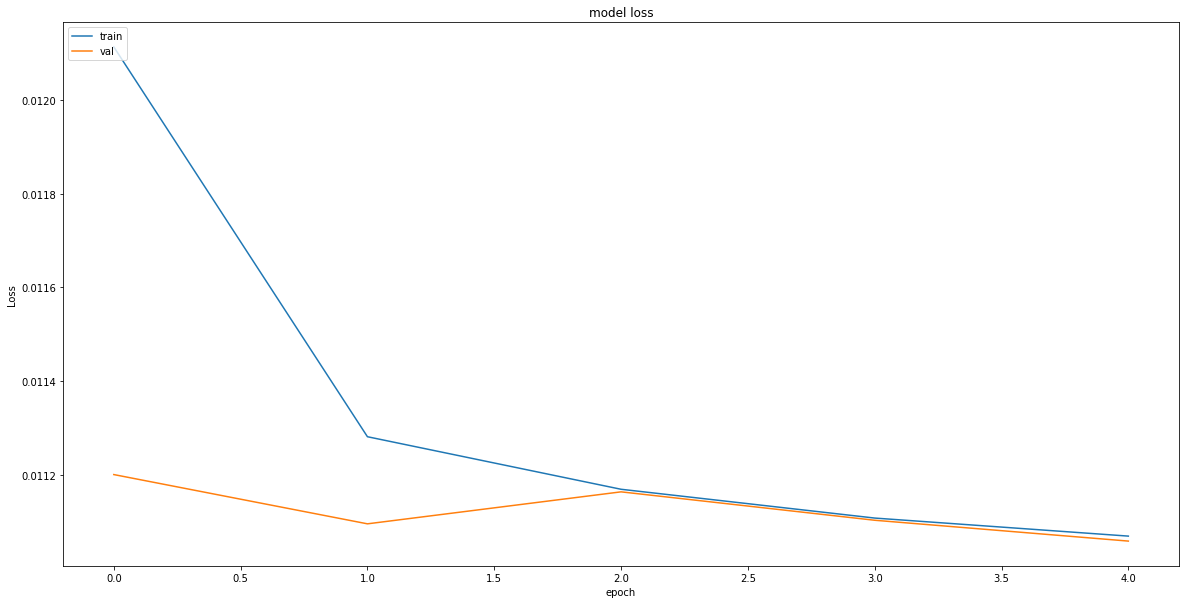

647/647 [==============================] - 1s 2ms/step - loss: 0.0111


0.011059130541980267

In [109]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot()

x = np.arange(0,len(history.history['loss']))

ax.plot(x,history.history['loss'])
ax.plot(x,history.history['val_loss'])


plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
model.evaluate(x_test, y_test)

In [110]:
from keras.models import model_from_json

model_json = model.to_json()

with open("MODEL.json", "w") as json_file:
      json_file.write(model_json)

model.save_weights("UP.h5")

In [111]:
df = pd.read_csv("Test.csv")
del df['Unnamed: 0']

In [118]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#player = 'James Harden'
#df = df[df['Starters'] == player]
x_array, y_array, def_data = format(df, 5)

co = 20
actual = scaler_y.inverse_transform((y_array.reshape(-1,1)))
x_array = np.asarray(x_array).astype('float32')

_preds = model.predict(x_array)
preds = scaler_y.inverse_transform(_preds)

actual.shape, preds.shape

x = np.hstack((def_data, preds))

x_train = x[0:split,:]
y_train = actual[0:split,]
x_test = x[split:actual.shape[0],:]
y_test = actual[split:actual.shape[0]]

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

xg_reg.fit(x_train,y_train)
preds = xg_reg.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[03:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 9.305285


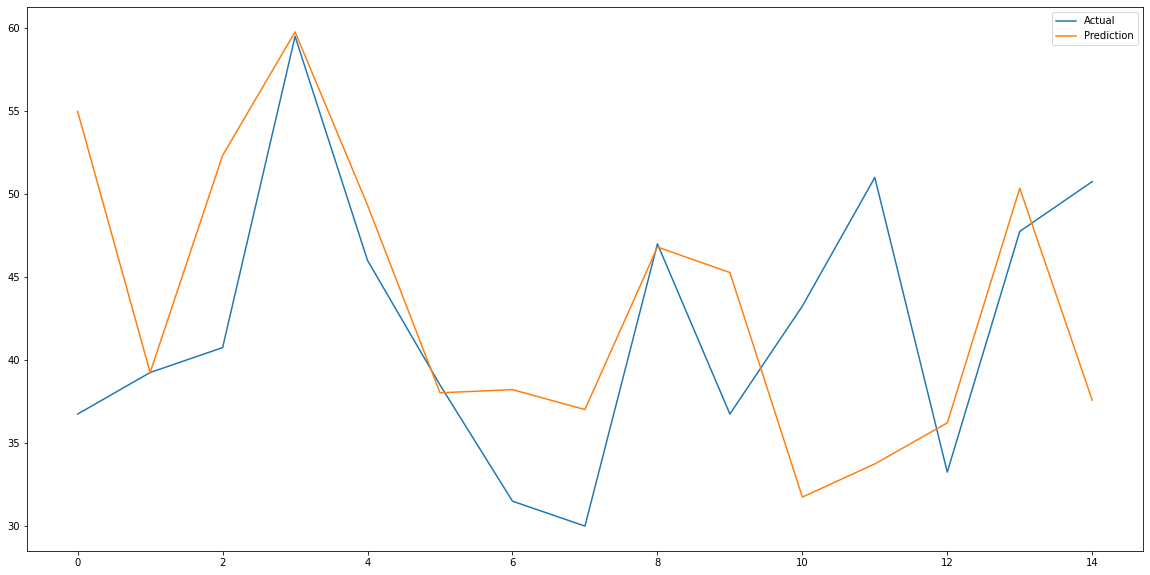

In [126]:
player = "Ben Simmons"
df_player = df[df['Starters'] == player]
x_array, y_array, def_data = format(df_player, 5)

actual = scaler_y.inverse_transform((y_array.reshape(-1,1)))
x_array = np.asarray(x_array).astype('float32')

_preds = model.predict(x_array)
preds = scaler_y.inverse_transform(_preds)
x_array = np.hstack((def_data, preds))

preds = xg_reg.predict(x_array)


fig = plt.figure(figsize=(20,10))
ax = plt.subplot()

co = 15
ax.plot(actual[-co:], label = 'Actual')
ax.plot(preds[-co:], label = 'Prediction')
ax.legend()
